# What's Cooking Kaggle Challenge

Link: https://www.kaggle.com/c/whats-cooking/overview

In this notebook I'll be looking at the dataset from the Kaggle What's Cooking Challenge which is a supervised problem of predicting cuisines from ingredients list. The dataset is a .json file with only 2 important columns being the cuisine as well as the ingredients. In this notebook we will be doing exploratory data analysis followed by using some Natural Language Processing techniques to solve the problem. I will be using PyTorch to implement the deep learning model to learn the vector representations of the words.

## Things to do: 
Add in a content page using Markdown
Segment the Notebook into different components
- Data Preprocessing
- Preliminary Model
- Data Visualisation - 1st Iteration
- CBOW Model
- NN Architecture
- Evaluation
- Visualisation - 2nd Iteration



In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn
import random


In [7]:
df = pd.read_json("datasets/train.json")
df_test = pd.read_json("datasets/test.json")
print(len(df))
print(len(df_test))
df.head()


39774
9944


,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [8]:
#Different Cuisines present and their counts
df["cuisine"].value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

In [9]:
ingredients = df["ingredients"].tolist()
test_ingredients = df_test["ingredients"].tolist()
ingredients = ingredients + test_ingredients

# The Vector space has to include all ingredients from both Train and Test

In [10]:
ingredients_dict = {}
for recipe in ingredients:
    for ingredient in recipe:
        ingredients_dict[ingredient] = ingredients_dict.get(ingredient,0)+ 1

ing_df = pd.DataFrame(data = ingredients_dict.values(),index = ingredients_dict.keys(),columns = ["Counts"])
ing_df.sort_values(["Counts"],ascending = False, inplace = True)
ing_df

,Counts
salt,22534
onions,10008
olive oil,9889
water,9293
garlic,9171
...,...
seville orange juice,1
dried hibiscus blossoms,1
pancake batter,1
dairy free coconut ice cream,1


As can be seen from the dataframe, there are currently 7137 differnt types of ingredients present in the dataset. However many of them are repeated but have a slightly different name in the recipe. (Eg. Garlic vs Chopped Garlic). Below you can see a list of stopwords which are redundant. This results in a reduction of the number of ingredients by around 200 which is relatively sizeable. 

In [11]:
stopwords= ["fresh","chopped","large","all-purpose","grated","freshly","crushed","minced","skinless"
           "sodium","low","diced","unsalted","coarse","low-fat","medium","powdered","finely","fine",
           "pitted","plain","low-fat","full-fat","nonfat","fat-free"]
def find_occurence(word,recipe_list): 
    #Utility function to check if an ingredient is present in the list of recipes
    result = {}
    for recipe in recipe_list:
        for ingredient in recipe:
            if word in ingredient:
                result[ingredient] = result.get(ingredient,0) + 1
    return list(result.keys())

ingredients2 = []
for index,i in enumerate(ingredients):
    recipe = []
    for j in i:
        ing_word = j.split(" ")
        ing_word = [i for i in ing_word if i not in stopwords]
        recipe.append(" ".join(ing_word))
    ingredients2.append(recipe)
ingredients = ingredients2[:]

ingredients_dict2 = {}
for recipe in ingredients:
    for ingredient in recipe:
        ingredients_dict2[ingredient] = ingredients_dict2.get(ingredient,0)+ 1
ing_df = pd.DataFrame(data = ingredients_dict2.values(),index = ingredients_dict2.keys(),columns = ["Counts"])
ing_df.sort_values(["Counts"],ascending = False, inplace = True)
df["ingredients"]= ingredients[:len(df)] #Append the "cleaned" list of ingredients to the dataframe
ingredients_map = {k:v for k,v in zip(ing_df.index,range(len(ing_df)))}

def convert_recipe(recipe):
    '''
    Convert Recipe from a List of String Ingredients to a Vector
    recipe: List of Ingredients
    output: 7137x1 Vector
    '''
    output = np.zeros(7137)
    for ingredient in recipe:
        output[ingredients_map[ingredient]] = 1
    return output
    
df["Vector"] = df["ingredients"].apply(convert_recipe) # Convert each recipe to a OHE Sparse Vector Form

Now that most of the preprocessing is done, traditional ML methods are used as a baseline effectiveness for the classification task so that we can compare the performance using Deep Learning.

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["Target"] = le.fit_transform(df["cuisine"])

Things to do:
- Reduce dimensionality of the data by removing redundant words
- Turning everything into a one hot encoded vector
- K-Means Clustering to treat the problem like an unsupervised one
- KNN, SVM vs Neural Network
- Use additional feature engineering to enhance model performance - Protein, spices others etc.


In [ ]:
#Store all the vectors as a Matrix of M x 7137
mat = list(df["Vector"])
mat = np.array(mat)
mat.shape

Because of the curse of dimensionality, training a model on this vector space will take way too long. For this we first use a linear dimensionality reduction tool PCA and later in the Natural Language Processing Section we can see how this actually compares with non-linear methods such as using an autoencoder

In [ ]:
from sklearn.decomposition import PCA
pca_128 = PCA(128)
mat_pca_128 = pca_128.fit_transform(mat)

In [ ]:
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(mat_pca_128,df['Target'],
                                                    test_size=0.30)
sv_linear = SVC(kernel = "linear")
sv_linear.fit(X_train,y_train)

In [32]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

predictions = sv_linear.predict(X_test)
print(classification_report(y_test,predictions))
cr = classification_report(y_test,predictions,output_dict= True)

              precision    recall  f1-score   support

           0       0.40      0.20      0.27       144
           1       0.30      0.17      0.22       236
           2       0.73      0.66      0.69       451
           3       0.72      0.80      0.76       769
           4       0.63      0.53      0.57       212
           5       0.47      0.52      0.49       748
           6       0.67      0.60      0.63       346
           7       0.85      0.86      0.85       886
           8       0.40      0.17      0.24       218
           9       0.72      0.84      0.77      2353
          10       0.81      0.57      0.67       162
          11       0.70      0.55      0.61       433
          12       0.72      0.57      0.64       242
          13       0.87      0.88      0.88      1961
          14       0.76      0.64      0.69       248
          15       0.41      0.30      0.35       139
          16       0.58      0.73      0.65      1334
          17       0.61    

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c= df["Target"])

plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(x_pca,df['Target'],
                                                    test_size=0.30)

In [ ]:
svm = SVC()
svm.fit(X_train,y_train)



In [ ]:
predictions = svm.predict(X_test)

In [ ]:
score = sum(y_test == predictions)/len(y_test)
score

In [ ]:
subset_df = df[df["Target"] < 6]
subset = list(subset_df["Vector"])
subset = np.array(subset)
x_pca = pca.fit_transform(subset)

In [ ]:
sns.scatterplot(x = x_pca[:,0], y = x_pca[:,1],hue = subset_df["Target"])
plt.legend()

In [ ]:
le.inverse_transform(range(0,6))

In [ ]:
sns.set_style('whitegrid')

## Natural Language Processing

Now that we have seen how something like PCA can make sense of the data, we come to the interesting part which is to try to find a better vector representation of the words in a recipe.

Here we will use the Common Bag Of Words (CBOW) model in order to learn the representation of the words. The idea behind CBOW is to use the context of a word to learn what the word actually means. For example a sentence such as "I like to eat pasta", in order to learn the representation of the word "eat", we look at "pasta" and "like" as context words. In this case because the recipes are inherently unordered, the context words will be obtained randomly from the sample.

The implementation of this model is to use an autoencoder architecture where the One-Hot encoded word vectors are used in the model as inputs and encoded into the learnt representations and then the decoder will try to recreate the target word. 

Link: https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa

## To-Do: Insert picture of the autoencoder
    

Recipe Sampling, Randomly choose 5 other ingredients that are in the same recipe and try to use the words to learn the representation of that word

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [14]:
df = pd.concat([df,df_test]) # This is to train the Language Model on the entire set of ingredients

stopwords= ["fresh","chopped","large","all-purpose","grated","freshly","crushed","minced","skinless"
           "sodium","low","diced","unsalted","coarse","low-fat","medium","powdered","finely","fine",
           "pitted","plain","low-fat","full-fat","nonfat","fat-free"]
def find_occurence(word,recipe_list):
    result = {}
    for recipe in recipe_list:
        for ingredient in recipe:
            if word in ingredient:
                result[ingredient] = result.get(ingredient,0) + 1
    return list(result.keys())

ingredients2 = []
for index,i in enumerate(ingredients):
    recipe = []
    for j in i:
        ing_word = j.split(" ")
        ing_word = [i for i in ing_word if i not in stopwords]
        recipe.append(" ".join(ing_word))
    ingredients2.append(recipe)
ingredients = ingredients2[:]

ingredients_dict2 = {}
for recipe in ingredients2:
    for ingredient in recipe:
        ingredients_dict2[ingredient] = ingredients_dict2.get(ingredient,0)+ 1
ing_df = pd.DataFrame(data = ingredients_dict2.values(),index = ingredients_dict2.keys(),columns = ["Counts"])
ing_df.sort_values(["Counts"],ascending = False, inplace = True)
df["ingredients"]= ingredients[:len(df)] #Append the "cleaned" list of ingredients to the dataframe
ingredients_map = {k:v for k,v in zip(ing_df.index,range(len(ing_df)))}

def convert_recipe(recipe):
    '''
    Convert Recipe from a List of String Ingredients to a Vector
    recipe: List of Ingredients
    output: 7137x1 Vector
    '''
    output = np.zeros(7137)
    for ingredient in recipe:
        output[ingredients_map[ingredient]] = 1
    return output
    
df["Vector"] = df["ingredients"].apply(convert_recipe) # Convert each recipe to a OHE Sparse Vector Form

C:\Users\reone\Anaconda3\envs\pytorch37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [15]:
#Helper Functions
CONTEXT_SIZE = 4
#The sampling function to get context words from a recipe
def sample(recipe,ingredient,samples):
    recipe = recipe[:] #Copy the recipe to prevent alteration
    recipe.remove(ingredient)
    if len(recipe) < CONTEXT_SIZE+1:
        context = random.choices(recipe, k=samples) #With Replacement when they are insufficient ingredients in the recipe
    else: 
        context = random.sample(recipe, k=samples) #Without Replacement 
    return context
def createVector(context):
    idxs = [ingredients_map[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)
class RecipeDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [21]:
'''samples = []
for recipe in df["ingredients"]:
    for ingredient in recipe[::2]:
        if len(recipe) > 2:
            samples.append([sample(recipe,ingredient,CONTEXT_SIZE),ingredient])
samples_idx = []
for context,target in samples:
    target_idx = (torch.tensor([ingredients_map[target]], dtype=torch.long))
    samples_idx.append([createVector(context),target_idx])'''
def loadData(dataCol,batch_size):
    samples = []
    for recipe in dataCol:
        for ingredient in recipe:
            if len(recipe) > 2:
                samples.append([sample(recipe,ingredient,CONTEXT_SIZE),ingredient])
    samples_idx = []
    for context,target in samples:
        target_idx = (torch.tensor([ingredients_map[target]], dtype=torch.long))
        samples_idx.append([createVector(context),target_idx])
    
    sample_DS = RecipeDataset(samples_idx)
    train_loader = DataLoader(dataset=sample_DS, batch_size=batch_size, shuffle=True)
    return train_loader
#train_loader= loadData(df["ingredients"],64)

In [21]:
len(sample_DS)

280032

In [48]:
VOCAB_SIZE = len(ingredients_dict2)
EMBED_DIM = 20

class CBOWModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        self.context_size = context_size
        self.embedding_dim = embedding_dim
        super(CBOWModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim) #Transform to Lower Dimension Embeddings
        self.linear1 = nn.Linear(context_size*embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)
        
    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((-1,self.context_size*self.embedding_dim))
        #print(embeds.size())
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        return out
    def getEmbeds(self,wordVec):
        return self.embeddings(wordVec)
        
cbow = CBOWModel(VOCAB_SIZE,EMBED_DIM,CONTEXT_SIZE)

In [70]:
l_rs = [0.1,0.25,0.5,1,2]
#Code to find ideal learning Rate for the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0)

loss_dict = {}
num_epochs = 25
iter_ = 0
BATCH_SIZE = 128
for l_r in l_rs:
    losses = []
    cbow = CBOWModel(VOCAB_SIZE,EMBED_DIM,CONTEXT_SIZE)
    cbow.to(device)
    optimizer = torch.optim.SGD(cbow.parameters(), lr=l_r) 
    print("Learning Rate:",l_r)
    for epoch in range(num_epochs):
        total_loss = 0
        for i,(context,target) in enumerate(train_loader):
            context = context.to(device)
            target =target.to(device)
            optimizer.zero_grad()
            outputs = cbow(context)
            target = target.view(-1)
            loss = criterion(outputs,target)
            loss.backward()
            optimizer.step()
            iter_  += 1
            total_loss +=loss.item()
            if iter_%500 ==0:
                print("Progress:",iter_*BATCH_SIZE/(num_epochs*len(sample_DS))*100,"%")
    
        losses.append(total_loss)
    loss_dict[l_r] = losses


Progress: 0.11427265455376527 %
Progress: 0.22854530910753054 %
Progress: 0.34281796366129585 %
Progress: 0.4570906182150611 %
Progress: 0.5713632727688265 %
Progress: 0.6856359273225917 %
Progress: 0.799908581876357 %
Progress: 0.9141812364301222 %
Progress: 1.0284538909838876 %
Progress: 1.142726545537653 %
Progress: 1.256999200091418 %
Progress: 1.3712718546451834 %
Progress: 1.4855445091989488 %
Progress: 1.599817163752714 %
Progress: 1.7140898183064794 %
Progress: 1.8283624728602443 %
Progress: 1.9426351274140097 %
Progress: 2.0569077819677752 %
Progress: 2.1711804365215404 %
Progress: 2.285453091075306 %
Progress: 2.399725745629071 %
Progress: 2.513998400182836 %
Progress: 2.6282710547366013 %
Progress: 2.742543709290367 %
Progress: 2.856816363844132 %
Progress: 2.9710890183978975 %
Progress: 3.0853616729516626 %
Progress: 3.199634327505428 %
Progress: 3.3139069820591933 %
Progress: 3.428179636612959 %
Progress: 3.5424522911667236 %
Progress: 3.6567249457204887 %
Progress: 3.7709

Progress: 30.853616729516624 %
Progress: 30.96788938407039 %
Progress: 31.082162038624155 %
Progress: 31.19643469317792 %
Progress: 31.310707347731686 %
Progress: 31.42498000228545 %
Progress: 31.539252656839217 %
Progress: 31.653525311392983 %
Progress: 31.767797965946748 %
Progress: 31.882070620500514 %
Progress: 31.99634327505428 %
Progress: 32.110615929608045 %
Progress: 32.22488858416181 %
Progress: 32.339161238715576 %
Progress: 32.45343389326934 %
Progress: 32.56770654782311 %
Progress: 32.68197920237687 %
Progress: 32.79625185693064 %
Progress: 32.910524511484404 %
Progress: 33.02479716603817 %
Progress: 33.139069820591935 %
Progress: 33.2533424751457 %
Progress: 33.367615129699466 %
Progress: 33.48188778425323 %
Progress: 33.59616043880699 %
Progress: 33.710433093360756 %
Progress: 33.82470574791452 %
Progress: 33.93897840246829 %
Progress: 34.05325105702205 %
Progress: 34.16752371157582 %
Progress: 34.28179636612958 %
Progress: 34.39606902068335 %
Progress: 34.510341675237115

Progress: 61.82150611358702 %
Progress: 61.93577876814078 %
Progress: 62.05005142269455 %
Progress: 62.16432407724831 %
Progress: 62.27859673180208 %
Progress: 62.39286938635584 %
Progress: 62.50714204090961 %
Progress: 62.62141469546337 %
Progress: 62.735687350017145 %
Progress: 62.8499600045709 %
Progress: 62.964232659124676 %
Progress: 63.078505313678434 %
Progress: 63.19277796823221 %
Progress: 63.307050622785965 %
Progress: 63.42132327733974 %
Progress: 63.535595931893496 %
Progress: 63.64986858644727 %
Progress: 63.76414124100103 %
Progress: 63.8784138955548 %
Progress: 63.99268655010856 %
Progress: 64.10695920466233 %
Progress: 64.22123185921609 %
Progress: 64.33550451376986 %
Progress: 64.44977716832362 %
Progress: 64.5640498228774 %
Progress: 64.67832247743115 %
Progress: 64.79259513198492 %
Progress: 64.90686778653868 %
Progress: 65.02114044109246 %
Progress: 65.13541309564621 %
Progress: 65.24968575019999 %
Progress: 65.36395840475375 %
Progress: 65.47823105930752 %
Progress

Progress: 93.24648611587247 %
Progress: 93.36075877042623 %
Progress: 93.47503142498 %
Progress: 93.58930407953376 %
Progress: 93.70357673408753 %
Progress: 93.81784938864129 %
Progress: 93.93212204319506 %
Progress: 94.04639469774882 %
Progress: 94.1606673523026 %
Progress: 94.27494000685635 %
Progress: 94.38921266141013 %
Progress: 94.50348531596389 %
Progress: 94.61775797051766 %
Progress: 94.73203062507142 %
Progress: 94.84630327962519 %
Progress: 94.96057593417895 %
Progress: 95.07484858873272 %
Progress: 95.18912124328648 %
Progress: 95.30339389784025 %
Progress: 95.41766655239401 %
Progress: 95.53193920694778 %
Progress: 95.64621186150154 %
Progress: 95.76048451605531 %
Progress: 95.87475717060907 %
Progress: 95.98902982516285 %
Progress: 96.1033024797166 %
Progress: 96.21757513427038 %
Progress: 96.33184778882413 %
Progress: 96.44612044337791 %
Progress: 96.56039309793167 %
Progress: 96.67466575248544 %
Progress: 96.7889384070392 %
Progress: 96.90321106159297 %
Progress: 97.017

Progress: 123.87155753628156 %
Progress: 123.98583019083533 %
Progress: 124.1001028453891 %
Progress: 124.21437549994285 %
Progress: 124.32864815449662 %
Progress: 124.44292080905039 %
Progress: 124.55719346360416 %
Progress: 124.67146611815791 %
Progress: 124.78573877271168 %
Progress: 124.90001142726545 %
Progress: 125.01428408181923 %


In [49]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cbow = CBOWModel(VOCAB_SIZE,EMBED_DIM,CONTEXT_SIZE)
torch.cuda.set_device(0)
cbow.to(device)
losses = []
num_epochs = 20
iter_ = 0
BATCH_SIZE = 128
learning_rate = 0.8
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cbow.parameters(), lr=learning_rate)  
for epoch in range(num_epochs):
    total_loss = 0
    if epoch%4 == 0:
        train_loader = loadData(df["ingredients"],BATCH_SIZE)
    for i,(context,target) in enumerate(train_loader):
        context = context.to(device)
        target =target.to(device)
        optimizer.zero_grad()
        outputs = cbow(context)
        target = target.view(-1)
        loss = criterion(outputs,target)
        loss.backward()
        optimizer.step()
        iter_  += 1
        total_loss +=loss.item()
        if iter_%500 ==0:
            print("Progress:",iter_/(num_epochs*len(train_loader))*100,"%")
    
    losses.append(total_loss)

print(losses)

Progress: 0.597943075819182 %
Progress: 1.195886151638364 %
Progress: 1.793829227457546 %
Progress: 2.391772303276728 %
Progress: 2.98971537909591 %
Progress: 3.587658454915092 %
Progress: 4.1856015307342735 %
Progress: 4.783544606553456 %
Progress: 5.381487682372638 %
Progress: 5.97943075819182 %
Progress: 6.577373834011002 %
Progress: 7.175316909830184 %
Progress: 7.773259985649367 %
Progress: 8.371203061468547 %
Progress: 8.96914613728773 %
Progress: 9.567089213106913 %
Progress: 10.165032288926094 %
Progress: 10.762975364745277 %
Progress: 11.36091844056446 %
Progress: 11.95886151638364 %
Progress: 12.556804592202822 %
Progress: 13.154747668022004 %
Progress: 13.752690743841187 %
Progress: 14.350633819660368 %
Progress: 14.948576895479551 %
Progress: 15.546519971298734 %
Progress: 16.144463047117917 %
Progress: 16.742406122937094 %
Progress: 17.34034919875628 %
Progress: 17.93829227457546 %
Progress: 18.53623535039464 %
Progress: 19.134178426213825 %
Progress: 19.732121502033007 %


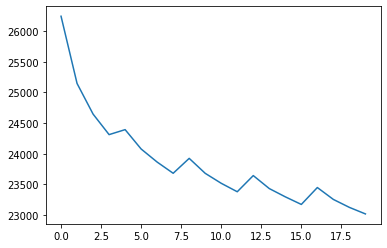

In [50]:
plt.plot(losses)

In [51]:
out = cbow.forward(hi)

In [52]:
hi = torch.tensor([1,0,0,0])
hi = hi.to(device)

In [54]:
out

tensor([[-3.4385,  4.8261,  8.4366,  ..., -1.6990, -1.4244, -1.3252]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [58]:
F.softmax(out).sum()

C:\Users\reone\Anaconda3\envs\pytorch37\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

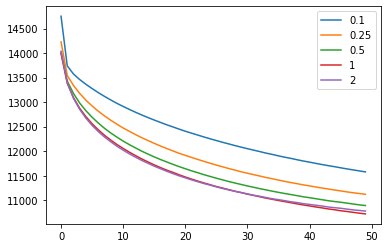

In [71]:
for l_r,losses in loss_dict.items():
    plt.plot(losses,label = l_r)
    
plt.legend()

In [168]:
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images with gradient accumulation capabilities
        images = images.view(-1, 28*28).requires_grad_()
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                # Load images with gradient accumulation capabilities
                images = images.view(-1, 28*28).requires_grad_()
                
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                # Total correct predictions
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / total
            
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

[[tensor([319, 262, 191, 456]), tensor([256])],
 [tensor([470,  32, 256, 191]), tensor([262])],
 [tensor([ 14, 456, 191, 470]), tensor([319])],
 [tensor([470,  32, 191, 256]), tensor([1])],
 [tensor([319, 191, 470,  32]), tensor([14])],
 [tensor([ 14, 470,   1, 319]), tensor([32])],
 [tensor([256, 319, 191,  14]), tensor([470])],
 [tensor([262, 191, 470,   1]), tensor([456])],
 [tensor([  1, 256, 319, 456]), tensor([191])],
 [tensor([13, 74, 11, 26]), tensor([9])],
 [tensor([ 0, 10, 26, 74]), tensor([51])],
 [tensor([13, 26, 10,  8]), tensor([0])],
 [tensor([ 13,  51, 592,   0]), tensor([10])],
 [tensor([ 13,  74,  51, 211]), tensor([11])],
 [tensor([ 51,   9, 211,   0]), tensor([74])],
 [tensor([ 9,  0, 51, 11]), tensor([8])],
 [tensor([11, 26,  9,  8]), tensor([592])],
 [tensor([ 74, 592,  26,  11]), tensor([211])],
 [tensor([211,  74,  11, 592]), tensor([26])],
 [tensor([51,  9, 26, 74]), tensor([13])],
 [tensor([  4,  63, 785,   0]), tensor([8])],
 [tensor([  4,  87, 103, 785]), te

In [157]:
dataset = torch.tensor(samples_idx,dtype = torch.long)

ValueError: only one element tensors can be converted to Python scalars

In [ ]:
sample1 = sample(ingredients[1],"flour",CONTEXT_SIZE)
sample1

In [80]:
ingredients_map

{'salt': 0,
 'garlic': 1,
 'onions': 2,
 'olive oil': 3,
 'butter': 4,
 'water': 5,
 'garlic cloves': 6,
 'sugar': 7,
 'eggs': 8,
 'flour': 9,
 'tomatoes': 10,
 'ground black pepper': 11,
 'cilantro': 12,
 'vegetable oil': 13,
 'pepper': 14,
 'ginger': 15,
 'soy sauce': 16,
 'kosher salt': 17,
 'lemon juice': 18,
 'green onions': 19,
 'carrots': 20,
 'parmesan cheese': 21,
 'ground cumin': 22,
 'extra-virgin olive oil': 23,
 'black pepper': 24,
 'lime juice': 25,
 'milk': 26,
 'parsley': 27,
 'chili powder': 28,
 'oil': 29,
 'red bell pepper': 30,
 'scallions': 31,
 'purple onion': 32,
 'onion': 33,
 'corn starch': 34,
 'shrimp': 35,
 'sesame oil': 36,
 'jalapeno chilies': 37,
 'baking powder': 38,
 'dried oregano': 39,
 'sour cream': 40,
 'chicken broth': 41,
 'cayenne pepper': 42,
 'lime': 43,
 'cooking spray': 44,
 'brown sugar': 45,
 'shallots': 46,
 'green bell pepper': 47,
 'garlic powder': 48,
 'basil': 49,
 'celery': 50,
 'ground pepper': 51,
 'honey': 52,
 'vanilla extract': 5

In [55]:
ingredients_map

{'salt': 0,
 'garlic': 1,
 'onions': 2,
 'olive oil': 3,
 'butter': 4,
 'water': 5,
 'garlic cloves': 6,
 'sugar': 7,
 'eggs': 8,
 'flour': 9,
 'tomatoes': 10,
 'ground black pepper': 11,
 'cilantro': 12,
 'vegetable oil': 13,
 'pepper': 14,
 'ginger': 15,
 'soy sauce': 16,
 'kosher salt': 17,
 'lemon juice': 18,
 'green onions': 19,
 'carrots': 20,
 'parmesan cheese': 21,
 'ground cumin': 22,
 'extra-virgin olive oil': 23,
 'black pepper': 24,
 'lime juice': 25,
 'milk': 26,
 'parsley': 27,
 'chili powder': 28,
 'oil': 29,
 'red bell pepper': 30,
 'scallions': 31,
 'purple onion': 32,
 'onion': 33,
 'corn starch': 34,
 'shrimp': 35,
 'sesame oil': 36,
 'jalapeno chilies': 37,
 'baking powder': 38,
 'dried oregano': 39,
 'sour cream': 40,
 'chicken broth': 41,
 'cayenne pepper': 42,
 'lime': 43,
 'cooking spray': 44,
 'brown sugar': 45,
 'shallots': 46,
 'green bell pepper': 47,
 'garlic powder': 48,
 'basil': 49,
 'celery': 50,
 'ground pepper': 51,
 'honey': 52,
 'vanilla extract': 5

In [88]:
torch.save.

In [89]:
test = cbow(sample1)

In [91]:
test.size()

torch.Size([1, 6837])